<a href="https://colab.research.google.com/github/xy2119/GNN_with_Causal_Knowledge/blob/main/notebooks/2_node_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook learns node embeddings by DeepWalk and Node2Vec

In [ ]:
!pip install --upgrade gensim
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.8 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 51 kB 209 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=f63cbf61823bf016ea4aee808978cc07160ccf91665fdcd260c4d948b7f00b8b
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import pandas as pd
import numpy as np 
import gensim

import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from node2vec import Node2Vec
from tqdm import tqdm
import random

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving criteo_edge_index.csv to criteo_edge_index.csv
Saving criteo_train.csv to criteo_train.csv


In [ ]:
import io
#df=pd.read_csv(io.BytesIO(uploaded['criteo_train.csv']),index_col=0)
df=pd.read_csv('criteo_train.csv',index_col=0)
df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,T,y,visit,tau
794547,24.441795,10.059654,8.214383,4.679882,10.280525,3.013064,-2.411115,10.691813,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
1724469,23.724135,10.059654,8.632714,4.679882,10.280525,4.115453,-5.987667,4.833815,3.832437,16.226044,5.300375,-0.168679,0,0,0,0
2768259,12.616365,10.059654,8.400390,4.679882,10.280525,4.115453,0.294443,4.833815,3.880455,30.046981,5.300375,-0.168679,0,0,0,0
1679134,12.616365,10.059654,8.734939,4.679882,10.280525,4.115453,0.294443,4.833815,3.943716,13.190056,5.300375,-0.168679,1,0,0,0
2594484,12.616365,10.059654,8.784306,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692743,22.761726,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
2356330,22.427641,10.059654,8.214383,4.679882,10.280525,4.115453,-5.576414,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
2229084,12.616365,10.059654,8.409980,4.679882,10.280525,4.115453,0.294443,4.833815,3.778512,39.140336,5.300375,-0.168679,1,0,0,0
2768307,12.616365,10.059654,9.037182,4.679882,10.280525,4.115453,0.294443,4.833815,3.934656,13.190056,5.300375,-0.168679,1,0,0,0


In [ ]:
col=df.columns
y=torch.from_numpy((np.array(df['y']))).reshape(df.shape[0],1).to(torch.float32)
x=torch.from_numpy(np.array(df[[c for c in df.columns[:-4]]+["visit"]+["T"]])).to(torch.float32)
x=x[0].reshape(-1,1)
y=y[0].reshape(-1,1)

# load edge index
edge_index=pd.read_csv('criteo_edge_index.csv')
edge_index=torch.from_numpy(np.transpose(np.array(edge_index)))

data=Data(x=x,edge_index=edge_index,y=y)

In [ ]:
random_walks = []
def get_randomwalk(node, path_length):
    
    random_walk = [node] 
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk
    
G=to_networkx(data)
all_nodes=list(G.nodes())

for n in tqdm(all_nodes):
    for i in range(20):
        random_walks.append(get_randomwalk(n,50))

100%|██████████| 15/15 [00:00<00:00, 1018.79it/s]


In [ ]:
df[[c for c in df.columns[:-4]]+["visit"]+["T"]]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,visit,T
794547,24.441795,10.059654,8.214383,4.679882,10.280525,3.013064,-2.411115,10.691813,3.971858,13.190056,5.300375,-0.168679,0,1
1724469,23.724135,10.059654,8.632714,4.679882,10.280525,4.115453,-5.987667,4.833815,3.832437,16.226044,5.300375,-0.168679,0,0
2768259,12.616365,10.059654,8.400390,4.679882,10.280525,4.115453,0.294443,4.833815,3.880455,30.046981,5.300375,-0.168679,0,0
1679134,12.616365,10.059654,8.734939,4.679882,10.280525,4.115453,0.294443,4.833815,3.943716,13.190056,5.300375,-0.168679,0,1
2594484,12.616365,10.059654,8.784306,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692743,22.761726,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,1
2356330,22.427641,10.059654,8.214383,4.679882,10.280525,4.115453,-5.576414,4.833815,3.971858,13.190056,5.300375,-0.168679,0,1
2229084,12.616365,10.059654,8.409980,4.679882,10.280525,4.115453,0.294443,4.833815,3.778512,39.140336,5.300375,-0.168679,0,1
2768307,12.616365,10.059654,9.037182,4.679882,10.280525,4.115453,0.294443,4.833815,3.934656,13.190056,5.300375,-0.168679,0,1


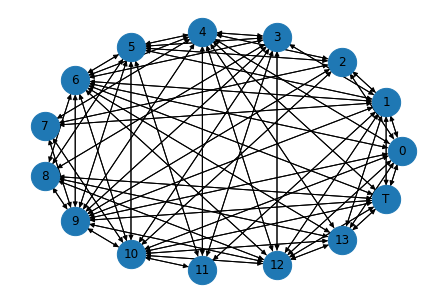

In [ ]:
def draw(Data):
    G = to_networkx(Data)
    mapping = {14:'T' }
    relabeled_G = nx.relabel_nodes(G,mapping)
    nx.draw_circular(relabeled_G,node_size=800,with_labels=True)
    plt.savefig("path.png")
    plt.show()
draw(data)

## Node embeddings generated from deepwalk

In [ ]:
model = Word2Vec(vector_size=10,window = 4, sg = 1, hs = 0,
                 negative = 3, alpha=0.03, min_alpha=0.0007,seed = 14)
model.build_vocab(random_walks, progress_per=5)
model.train(random_walks,total_examples = model.corpus_count, epochs=30, report_delay=1)
model.save(r"deepwalk_10d_x13.model")
#files.download("deepwalk_10d_x13.model")
model.wv.similar_by_word(1)

[(2, 0.8829315900802612),
 (11, 0.8777735829353333),
 (13, 0.877348780632019),
 (9, 0.8651714324951172),
 (8, 0.8566047549247742),
 (10, 0.8471066355705261),
 (4, 0.8383476734161377),
 (6, 0.8043029308319092),
 (0, 0.7850354909896851),
 (7, 0.771659791469574)]

## Node embeddings generated from Node2Vec

In [ ]:
import gensim
import node2vec
node2vec = Node2Vec(graph=G, dimensions=10, walk_length=50, num_walks=100, workers=4)  # Use temp_folder for big graphs
model = node2vec.fit(window=4, min_count=1, batch_words=4)  
model.save(r"Node2Vec_10d_x13.model")
#files.download("Node2Vec_10d_x13.model")
model.wv.similar_by_word(1)

Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

[('10', 0.9723686575889587),
 ('4', 0.9208940267562866),
 ('9', 0.9050049185752869),
 ('0', 0.8937731385231018),
 ('5', 0.8912699818611145),
 ('2', 0.8541372418403625),
 ('6', 0.8509217500686646),
 ('8', 0.8376321196556091),
 ('13', 0.8374010920524597),
 ('3', 0.8235973119735718)]